## Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 


In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


In [3]:
importlib.reload(data)
eigen_energies, emin, emax = data.load_eigenenergies(unpack = True, n_structures = n_structures)

This file contains the eigenenergies and their corresponding kpoints of the training Silicon structures generated using DFT PBE as implemented in FHI-AIMS version 171221_1 with the ``tight'' settings


In [6]:
sigma = 0.3
dx = 0.05

full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
eigenenergy_length = [len(i) for i in full_eigen_energies]
eigenenergy_length_t = torch.tensor(eigenenergy_length)
normalization_eiglength = [len(i) for i in eigen_energies]
normalization_eiglength_t = torch.tensor(normalization_eiglength)
normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms/normalization_eiglength_t
normalization_quartic = 1/n_atoms/normalization_eiglength_t


In [7]:
#Determine right_bound as highest eigenenergy
def determine_rightbounds(eigen_energies):
    right_bounds = []
    for energies in (eigen_energies):
        right_bound = torch.max(energies)
        right_bounds.append(right_bound)
    right_bounds = torch.vstack(right_bounds)
    return right_bounds


rbounds = determine_rightbounds(full_eigen_energies)

def determine_leftbounds(eigen_energies):
    left_bounds = []
    for energies in (eigen_energies):
        left_bound = torch.min(energies)
        left_bounds.append(left_bound)
    left_bounds = torch.vstack(left_bounds)
    return left_bounds
lbounds = determine_leftbounds(full_eigen_energies)


In [8]:
# Determine Fermi level with respect to upper bound
# Get core level references

In [9]:
# Fermi level
import ase

T_0 = 200
beta_0 = 1 / (ase.units.kB * T_0) # inverse temperature
efermi = np.zeros(n_structures)
for i in range(n_structures):
    efermi[i] = utils.getmu(ldos[i], beta_0, xdos, n=4)

In [10]:
max(efermi)

-4.375835372334838e+00

## Inspecting default train-test split and generating biased dataset

In [11]:
diamond_range = np.arange(0,324,1)
beta_tin_range = np.arange(324,604,1)
liquid_range = np.arange(604, 673, 1)
clusters_range = np.arange(673, 939, 1)
amorphous_range = np.arange(939, 1039, 1)
def find_structures_in_index(index):
    structures = {}
    structures['diamond'] =  np.sum(np.isin(index, diamond_range))
    structures['beta_tin'] = np.sum(np.isin(index, beta_tin_range))
    structures['liquid'] = np.sum(np.isin(index, liquid_range))
    structures['clusters'] = np.sum(np.isin(index, clusters_range))
    structures['amorphous'] = np.sum(np.isin(index, amorphous_range))
    
    return structures

train_structures = find_structures_in_index(train_index)

In [12]:
train_structures

{'diamond': 249,
 'beta_tin': 231,
 'liquid': 58,
 'clusters': 209,
 'amorphous': 84}

In [13]:
#Selected Amorphous structures

amorph_train = np.arange(939,1039,1)
np.random.seed(0)
np.random.shuffle(amorph_train)

amorph_test = amorph_train[:80]
amorph_train = amorph_train[80:]

n_structures2 = 939
np.random.seed(0)
n_train = int(0.8 * 1039)-20
remaining_train_index = np.arange(n_structures2)
np.random.shuffle(remaining_train_index)

remaining_test_index = remaining_train_index[n_train:]
remaining_train_index = remaining_train_index[:n_train]

biased_train_index = np.concatenate([remaining_train_index, amorph_train])
biased_test_index = np.concatenate([remaining_test_index, amorph_test])

In [14]:
biased_train_structures = find_structures_in_index(biased_train_index)

In [15]:
biased_train_structures

{'diamond': 278,
 'beta_tin': 244,
 'liquid': 60,
 'clusters': 229,
 'amorphous': 20}

## Quartic dataset

In [16]:
#Determine bounds
#Determine right_bound as highest eigenenergy
rbounds = determine_rightbounds(full_eigen_energies)
efermi = torch.tensor(efermi)

In [17]:
torch.max(efermi, dim = 0)

torch.return_types.max(
values=tensor(-4.3758),
indices=tensor(723))

In [18]:
torch.min(efermi, dim = 0)

torch.return_types.min(
values=tensor(-7.8526),
indices=tensor(346))

In [19]:
def quartic_dos(energies,xdos, sigma):
   
    left_b = energies - (np.sqrt(7) * sigma)

    output = torch.zeros_like(xdos)

    left_bound = torch.searchsorted(xdos, left_b)
    
    xdos_interval = xdos[1]-xdos[0]
    interval = int((2 * (np.sqrt(7) * sigma))/xdos_interval) + 1
    indexes = torch.clamp(left_bound.repeat(interval,1) + torch.arange(0,interval,1).view(-1,1), 0, len(xdos)-1)
                     
    E = torch.clamp((energies.view(1,-1) - xdos[indexes]), min = -1* (np.sqrt(7) * sigma), max = (np.sqrt(7) * sigma))
    values = (E**2 - (7 * (sigma**2))) **2 / ((16/15) * (np.sqrt(7) * sigma)**5)
    output.index_add_(0, indexes.flatten(), values.flatten())

#     output = -1 * output
    
    return output

In [20]:
#1
full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
sorted_full_eigen_energies = [torch.sort(i)[0] for i in full_eigen_energies]
# #2
# #Sticking to sigma=0.3, 2eV above the max fermi level will correspond to max energy of 2.8ev above the max fermi level
# sorted_full_eigen_energies_2 = []
# for e in sorted_full_eigen_energies:
    
#     sorted_full_eigen_energies_2.append(e[:torch.searchsorted(e, torch.max(efermi) + 2.8)])
# #3
# sorted_full_eigen_energies_3 = []
# for i,e in enumerate(sorted_full_eigen_energies):    
#     sorted_full_eigen_energies_3.append(e[:torch.searchsorted(e, efermi[i] + 2.8)])

In [83]:
##Generate individual xdos, ldos
with torch.no_grad():

    n_xdos2 = []
    n_ldos2 = []

    sigma = torch.tensor(0.3)
    ndos = 778 #+ int(30/0.05)


    emin = -24.5537
    emax = 11.3464

    n_xdos2 = torch.linspace(emin - 1.5, emax + 1.5,ndos)

    for i in tqdm(range(1039)):
        #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)    
        l_dos2 = quartic_dos(sorted_full_eigen_energies[i], n_xdos2, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    #     n_xdos2.append(x_dos2)
        n_ldos2.append(l_dos2)

    # n_xdos2 = torch.vstack(n_xdos2)
    n_ldos2 = torch.vstack(n_ldos2)
    n_ldos2 = ((n_ldos2.T * normalization_quartic ).T)* 2

#Do cutting here?

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:05<00:00, 189.06it/s]


In [81]:
ldos.shape

torch.Size([1039, 778])

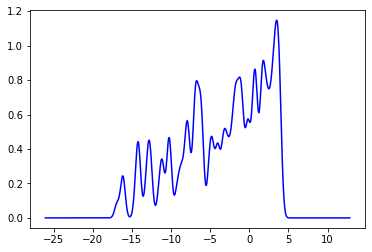

In [90]:
xdos = torch.tensor(data.load_xdos())
ldos = torch.tensor(data.load_ldos())
ldos *= 2

# plt.plot(xdos, n_ldos2[train_index[0]], c= 'r')
plt.plot(xdos, ldos[train_index[1]], c= 'b')

In [92]:
normalization_quartic[train_index[0]]

tensor(0.0006)

In [22]:
n_xdos2.shape

torch.Size([839])

In [219]:
##Generate shifted quartic dataset


full_xdos = []
shifted_full_ldos = []

sigma = torch.tensor(0.3)
# ndos = 778 #+ int(30/0.05)


emin = -24.5537
emax = 11.3464

true_alignments = (torch.rand(1039)-0.5) * 4

full_xdos = torch.arange(emin - 3, emax + 3,0.05)
for i in tqdm(range(n_structures)):
    #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)
    #x_dos2 = torch.linspace(emin - 1.5, emax + 1.5,ndos)
    shifted_full_ldos_i = quartic_dos(sorted_full_eigen_energies[i] + true_alignments[i], full_xdos, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
#     n_xdos2.append(x_dos2)
    shifted_full_ldos.append(shifted_full_ldos_i)
    
#n_xdos2 = torch.vstack(n_xdos2)
shifted_full_ldos = torch.vstack(shifted_full_ldos)
shifted_full_ldos = ((shifted_full_ldos.T * normalization_quartic ).T)* 2

#Do cutting here?

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:02<00:00, 353.08it/s]


In [164]:
# i = 700
# #plt.plot(n_xdos[i], n_ldos[i], c= 'r')
# plt.plot(xdos, ldos[i], c= 'b')
# plt.plot(xdos, n_ldos2[i], c= 'g')
# plt.vlines(x = efermi[i], ymin = -0.05, ymax = 0.7)

## Gradient descent in loss functions

In [166]:
from dostools.loss.loss import t_get_mse

In [22]:
#Goal is to only evaluate loss on the relevant energies
# 1) Need to know the range of relevant energies 
# 2) Should train the energy levels individually,
# 3) Need a dataset class
# 4) Model receives data and determines which one to feed to
# 5) Optimizer updates all relevant weights at once

# To define Loss
# 1) String together all the xdos, ldos values
# 2) Calculate loss on that interval

In [23]:
# Quartic polynomials
# 1) 

In [24]:
#Need to see if i should align all at once or just one at a time

In [58]:
def MSE_shift_discrete(pred: torch.tensor, target_eigvals: list, normalization:torch.tensor, xdos: torch.tensor, rbound:int, n_epochs:int, draw = False):
    #cannot rely solely on error values because pred might look different from target
    alignments = []
    all_mse = []
    sigma = 0.3
    patience = 20
    counter = 0
###DRAW
    if draw:
        fig, ax_list = plt.subplots(1,1)
    #     ax_list = ax_list.flatten()
        line, = ax_list.plot(xdos, pred[0], label = "Aligned True")
        z, = ax_list.plot(xdos, pred[0], label = "Prediction")
        ax_list.vlines(x = -2.3231, ymin = -0.05, ymax = 1, color = 'black')
        fig.legend([line,z], labels = ["Aligned True", "Prediction"], loc = "lower center")

    for i in tqdm(range(len(target_eigvals))):        
        xdos_i = xdos
        shift = torch.nn.parameter.Parameter(torch.tensor(0.))
        best_mse = torch.tensor(1)
        best_state = shift.clone()
        opt_LBFGS = torch.optim.LBFGS([shift], lr = 100, line_search_fn = 'strong_wolfe')#, weight_decay = 0)
        opt_adam = torch.optim.Adam([shift], lr = 1, weight_decay = 0)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, factor = 0.1, patience = 20, threshold = 1e-7, min_lr = 0.01)
        if draw:
            z.set_ydata(pred[i].detach().numpy())
        prev_mse = torch.tensor(1)
        for epoch in range(n_epochs):            
            opt_LBFGS.zero_grad()
            def closure():
                opt_LBFGS.zero_grad()
                ldos_i = quartic_dos(target_eigvals[i] + shift, xdos_i, sigma)
                ldos_i = ((ldos_i * normalization[i] ))* 2
                mse = loss.t_get_mse(pred[i,:rbound], ldos_i[:rbound])
                mse.backward()
                return mse
                            
            
            if epoch == 0:
                opt_LBFGS.step(closure)
            else:
                opt_adam.step(closure)
            
            with torch.no_grad():
                ldos_i = quartic_dos(target_eigvals[i] + shift, xdos_i, sigma)
                ldos_i = ((ldos_i * normalization[i] ))* 2
                mse = loss.t_get_mse(pred[i,:rbound], ldos_i[:rbound])
                scheduler.step(mse)
            if mse < best_mse:
                
                best_mse = mse.detach().clone()
                best_state = shift.detach().clone()
            
            if mse < prev_mse * (1 - 1e-3):
                counter = 0 
            else:
                counter +=1
            prev_mse = mse
#                 counter += 1
#                 if counter >= patience:
#                     shift = torch.nn.parameter.Parameter(torch.tensor(best_state))
#                     counter = 0
#             else:
                
##DRAW      
            if draw:
                ldos_i = quartic_dos(target_eigvals[i] + shift, xdos_i, sigma)
                ldos_i = ((ldos_i * normalization[i] ))* 2
                line.set_ydata(ldos_i.detach().numpy())
                fig.suptitle("Epochs: {}, Shift: {:.3}, Best Shift: {:.3}, Current loss:{:.3}, Best Loss: {:.3}, LR: {}".format(epoch, shift.item(), best_state.item(), mse.item(), best_mse.item(), opt_adam.param_groups[0]['lr']))
                fig.canvas.draw()
                fig.canvas.flush_events()
            
            
            if mse < 1e-10:
#                 print ("break at lr: {}, mse : {}, epoch : {}, shift: {}". format(opt.param_groups[0]['lr'], mse, epoch, shift.item()))
                break
            if best_mse.item() > 1e-5 and counter >= patience: #does not really work because i dont know when the error is unacceptable, maybe only applies to trained models?
                shift = torch.nn.parameter.Parameter(best_state)
                opt_adam = torch.optim.Adam([shift], lr = opt_adam.param_groups[0]['lr'], weight_decay = 0)
                counter = 0
                    
            if opt_adam.param_groups[0]['lr'] < 0.1 and (counter >= patience or mse.item() < 1e-10):
#                 print ("break at lr: {}, mse : {}, epoch : {}, shift: {}". format(opt.param_groups[0]['lr'], mse, epoch, shift.item()))
                break


        alignments.append(torch.tensor(best_state.item()))
        ldos_i = quartic_dos(target_eigvals[i] + shift, xdos_i, sigma)
        ldos_i = ((ldos_i * normalization_quartic[i] ))* 2
        mse = loss.t_get_mse(pred[i,:rbound], ldos_i[:rbound])
        all_mse.append(mse)
                
        
    all_mse = torch.vstack(all_mse)
    alignments = torch.vstack(alignments)
    
    return all_mse, alignments


In [ ]:
def MSE_shift_continuous(x_pred, target): #Should make the model repredict the DOS at a shifted energy value
    alignments = torch.nn.parameter.Parameter(torch.zeros(len(target)))
    pass

In [ ]:
def MSE_shift_fourier(x_pred, target):
    alignments = torch.nn.parameter.Parameter(torch.zeros(len(target)))
    pass

In [ ]:
def MSE_shift_continuous(pred, target): #shifts the prediction values, 1) want to extract the inner representation with a method. 2) modify the energy input values at the inner representation layer, 3) optimize the optimal alignment values 
    alignments = torch.nn.parameter.Parameter(torch.tensor(0.))
    pass

In [25]:
##Generate shifted quartic dataset


full_xdos = []
shifted_full_ldos = []

sigma = torch.tensor(0.3)
# ndos = 778 #+ int(30/0.05)


emin = -24.5537
emax = 11.3464

true_alignments = (torch.rand(1039)-0.5) * 4

full_xdos = torch.arange(emin - 1.5, emax + 3,0.05)
for i in tqdm(range(n_structures)):
    #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)
    #x_dos2 = torch.linspace(emin - 1.5, emax + 1.5,ndos)
    shifted_full_ldos_i = quartic_dos(sorted_full_eigen_energies[i] + true_alignments[i], full_xdos, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
#     n_xdos2.append(x_dos2)
    shifted_full_ldos.append(shifted_full_ldos_i)
    
#n_xdos2 = torch.vstack(n_xdos2)
shifted_full_ldos = torch.vstack(shifted_full_ldos)
shifted_full_ldos = ((shifted_full_ldos.T * normalization_quartic ).T)* 2

#Do cutting here?

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:02<00:00, 385.95it/s]


In [22]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [41]:

i = 0
j = 1039

mse3, shift3 = MSE_shift_discrete(shifted_full_ldos[i:i+j], sorted_full_eigen_energies[i:i+j], normalization_quartic[i:i+j], full_xdos, 479, 300, draw = False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [12:50<00:00,  1.35it/s]


## New Features


In [27]:
import rascaline
from skcosmo.feature_selection import FPS
import scipy

HYPER_PARAMETERS = {
    "cutoff": 4.0,#6.0,#4.0,
    "max_radial": 8,#12,#8,
    "max_angular": 6,#9,#6,
    "atomic_gaussian_width": 0.45,
    "center_atom_weight": 1.0,
    "radial_basis":{
        "Gto":{}
    },
    "cutoff_function":{
        "Step":{}, #maybe 
    },
    "radial_scaling":{
        "Willatt2018":{
        'exponent': 5,
        'rate' : 1,
        'scale' : 3.,
        },
    },
}

calculator = rascaline.SoapPowerSpectrum(**HYPER_PARAMETERS)
descriptors = calculator.compute(structures)
descriptors.keys_to_samples("species_center")
descriptors.keys_to_properties(["species_neighbor_1", "species_neighbor_2"])



n_refs = 200
n_atoms = descriptors.block(0).values.shape[0]
n_structures = np.unique(descriptors.block(0).samples["structure"])
feature = torch.zeros(len(n_structures), n_refs)
atom_descriptors = torch.tensor(descriptors.block(0).values)
atom_descriptors = torch.nn.functional.normalize(atom_descriptors, dim = 1)
selector = FPS(n_to_select = n_refs,
           progress_bar = True,
           score_threshold = 1e-12,
           full = False,
           initialize = 0
          )
selector.fit(atom_descriptors.T)
references = selector.transform(atom_descriptors.T).T
atomkernel_descriptors = torch.pow(atom_descriptors @ references.T, 2)
for structure_i in n_structures:
    a_i = descriptors.block(0).samples["structure"] == structure_i
    feature[structure_i, :] = torch.sum(atomkernel_descriptors[a_i, :], axis = 0)/np.sum(a_i)

kMM = references @ references.T
rtkMM = scipy.linalg.sqrtm(kMM)

  0%|          | 0/199 [00:00<?, ?it/s]

## Linalg-Shift, Full dataset


In [24]:
import dostools.loss.loss as loss

In [49]:
test_eigenenergies = [sorted_full_eigen_energies[i] for i in test_index]

In [75]:
from dostools.loss import loss
#normal dataset

batch_size = 64
sigma = 0.3
n_epochs = 50
patience = 20

index = train_index
t_index = test_index

Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

Features = torch.hstack([feature[index].double(), torch.ones(len(index)).view(-1,1)])
t_Features = torch.hstack([feature[t_index].double(), torch.ones(len(t_index)).view(-1,1)])
# Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
# t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))

opt = torch.optim.Adam([alignment], lr = 1e-3, weight_decay = 0)
# opt_LBFGS = torch.optim.LBFGS([alignment], lr = 1e-11, line_search_fn = 'strong_wolfe')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 5, threshold = 1e-7, min_lr = 1e-5)

xdos = n_xdos2
cutoff = torch.max(efermi) + 3
cutoff_index = torch.searchsorted(xdos, cutoff)

# ldos = shifted_full_ldos[index,:cutoff_index].clone()#
ldos = n_ldos2[index,:cutoff_index].clone()

train_ldos = ldos.clone()

best_mse = torch.tensor(100)
best_state = alignment.clone()

n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights

train_loss = loss.t_get_rmse(reference_pred, ldos, xdos[:cutoff_index], perc = True)
test_loss = loss.t_get_rmse(reference_t_pred, n_ldos2[t_index,:cutoff_index], xdos[:cutoff_index], perc = True)
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.4}".format(train_loss))
print ("Reference test loss : {:.4}".format(test_loss))


pbar = tqdm(range(n_epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), current_rmse = current_rmse.item(), trigger = trigger)
    
    for i_batch in Batcher:
        def closure():
            global train_ldos
            opt.zero_grad()
            for i in i_batch:
                ldos_i = quartic_dos(sorted_full_eigen_energies[index[i]] + alignment[i], xdos, sigma) * normalization_quartic[i] * 2
                train_ldos[i] = ldos_i[:cutoff_index]            
            reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
            train_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd").solution
            train_pred = Features @ train_weights
            loss_i = loss.t_get_mse(train_pred, train_ldos)
            loss_i.backward(inputs = alignment)
            train_ldos = train_ldos.detach()
            return loss_i
        opt.step(closure)
        train_ldos = train_ldos.detach()
        
    with torch.no_grad():
        train_ldos = []
        for i in range(len(index)):  
            l_dosi = quartic_dos(sorted_full_eigen_energies[index[i]] + alignment[i], xdos, sigma)
            
    #     n_xdos2.append(x_dos2)
            train_ldos.append(l_dosi[:cutoff_index])
    
    # n_xdos2 = torch.vstack(n_xdos2)
        train_ldos = torch.vstack(train_ldos)
        train_ldos = ((train_ldos.T * normalization_quartic[index] ).T)* 2
        reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
        weights_i = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd").solution
        pred_i = Features @ weights_i

        i_loss = loss.t_get_mse(pred_i, train_ldos)
        i_rmse = loss.t_get_rmse(pred_i, train_ldos, xdos[:cutoff_index], perc = True)
    
    
        pred_loss = i_loss
        if i_loss < prev_loss * (1 + 1e-3): 
            trigger = 0
        else:
            trigger +=1 
            if trigger >= patience:
                alignment = torch.nn.parameter.Parameter(best_state)
                opt = torch.optim.Adam([alignment], lr = opt.param_groups[0]['lr'], weight_decay = 0)
                opt_LBFGS = torch.optim.LBFGS([alignment], lr = opt_LBFGS.param_groups[0]['lr'], line_search_fn = 'strong_wolfe')
                counter = 0

        if i_loss < best_mse:
            best_mse = i_loss
            best_state = alignment.clone()
            print ("This is the best state")

        prev_loss = i_loss
        current_rmse = i_rmse

#         scheduler.step(i_loss)

#         if opt.param_groups[0]['lr'] < 1e-4:
#             break

best_state = torch.zeros(len(index))
shifted_ldos = []
for i in range(len(index)):
    shifted_ldos_i = quartic_dos(sorted_full_eigen_energies[index[i]] + torch.clamp(best_state[i], -3,3), xdos, sigma)[:cutoff_index]
    shifted_ldos.append(shifted_ldos_i)
    
shifted_ldos = torch.vstack(shifted_ldos)
shifted_ldos = ((shifted_ldos.T * normalization_quartic[index]).T) * 2
shifted_reg_target = torch.vstack([shifted_ldos, torch.zeros(n_col,shifted_ldos.shape[1])])
shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd", rcond = 1e-10).solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = loss.t_get_rmse(shifted_preds, shifted_ldos, xdos[:cutoff_index], perc = True)
# shifted_test_loss = MSE_shift_discrete(shifted_t_preds, test_eigenenergies, normalization[test_index], xdos, cutoff_index, 300) #Need the one with the new loss function


print ("Final training loss: {:.4}".format(shifted_train_loss))
# print ("Final test loss: {:.4}".format(shifted_test_loss))


Reference training loss: 10.03
Reference test loss : 11.51


Epoch: 1:   2%|█▉                                                                                                | 1/50 [00:13<11:01, 13.51s/it, current_rmse=10, lowest_mse=7.36e-5, pred_loss=7.36e-5, trigger=0]

This is the best state


Epoch: 2:   4%|███▉                                                                                             | 2/50 [00:30<12:07, 15.15s/it, current_rmse=10.1, lowest_mse=7.36e-5, pred_loss=7.4e-5, trigger=1]


KeyboardInterrupt: 

In [68]:
#Fix target regeneration

In [307]:
shifted_ldos = []
for i in range(len(index)):
    shifted_ldos_i = quartic_dos(sorted_full_eigen_energies[index[i]] + torch.clamp(best_state[i], -3,3), xdos, sigma)
    shifted_ldos.append(shifted_ldos_i)
    
shifted_ldos = torch.vstack(shifted_ldos)
shifted_ldos = ((shifted_ldos.T * normalization_quartic[index]).T) * 2

shifted_weights = torch.linalg.lstsq(Features, shifted_ldos[:,:cutoff_index], driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = loss.t_get_rmse(shifted_preds, shifted_ldos[:,:cutoff_index], xdos[:cutoff_index], perc = True)
# shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

print ("Final training loss: {:.4}".format(shifted_train_loss))


Final training loss: 2.507


In [311]:
regularization = 0
reg = regularization * torch.eye(n_col)
reg[n_col-1, n_col-1] = 0
reg_features = Features.T @ Features + reg
reference_weights = torch.linalg.lstsq(reg_features, Features.T @ n_ldos2[index,:cutoff_index], driver = "gelsd").solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights

train_loss = loss.t_get_rmse(reference_pred, n_ldos2[index, :cutoff_index], xdos[:cutoff_index], perc = True)
test_loss = loss.t_get_rmse(reference_t_pred, n_ldos2[t_index,:cutoff_index], xdos[:cutoff_index], perc = True)
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.4}".format(train_loss))
print ("Reference test loss : {:.4}".format(test_loss))


Reference training loss: 8.175
Reference test loss : 10.08


In [318]:
shifted_weights.shape

torch.Size([1001, 524])

In [320]:
Features.shape

torch.Size([831, 1001])

In [331]:
weight.shape

torch.Size([1001, 524])

In [ ]:
shifted_preds2

In [359]:
torch.linalg.cond(Features)

tensor(6.9378e+23)

In [361]:
Features = torch.hstack([Silicon.Features['structure_avekerneldescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
t_Features = torch.hstack([Silicon.Features['structure_avekerneldescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])


matinv = torch.linalg.inv(Features.T @ Features)
weight = matinv @ Features.T @ n_ldos2[index,:cutoff_index]

shifted_weights = torch.linalg.lstsq(Features.T @ Features, Features.T @ n_ldos2[index,:cutoff_index], driver = "gelsd", rcond = 1e-15).solution
shifted_preds = Features @ shifted_weights
# shifted_preds2 = Features @ weight


shifted_train_loss = loss.t_get_rmse(shifted_preds, n_ldos2[index,:cutoff_index], xdos[:cutoff_index], perc = True)
shifted_train_loss2 = loss.t_get_rmse(shifted_preds2, n_ldos2[index,:cutoff_index], xdos[:cutoff_index], perc = True)

# shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

print ("Final training loss: {:.4}".format(shifted_train_loss))
# print ("Final training loss2: {:.4}".format(shifted_train_loss2))

Final training loss: 5.389


In [308]:
regularization = 0
reg = regularization * torch.eye(n_col)
reg[n_col-1, n_col-1] = 0
reg_features = Features.T @ Features + reg
reference_weights = torch.linalg.lstsq(reg_features, Features.T @ shifted_ldos[:, :cutoff_index], driver = "gelsd").solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights

train_loss = loss.t_get_rmse(reference_pred, shifted_ldos[:, :cutoff_index], xdos[:cutoff_index], perc = True)
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.4}".format(train_loss))
print ("Reference test loss : {:.4}".format(test_loss))

Reference training loss: 11.7
Reference test loss : 10.08


In [290]:
alignment_1 = best_state.clone()

In [242]:
i_rmse = loss.t_get_rmse(pred_i, train_ldos, xdos[:cutoff_index], perc = True)

RuntimeError: trapezoid: There must be one `x` value for each sample point

In [245]:
cutoff_index

tensor(524)

In [243]:
pred_i.shape

torch.Size([831, 839])

In [244]:
train_ldos.shape

torch.Size([831, 839])

In [144]:
#normal dataset

batch_size = 831
sigma = 0.3
n_epochs = 10000
patience = 20

index = train_index
t_index = test_index

Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))

#opt = torch.optim.Adam([alignment], lr = 0.01, weight_decay = 0)
opt = torch.optim.LBFGS([alignment], lr = 100, line_search_fn = 'strong_wolfe')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 50, threshold = 1e-7, min_lr = 0.00001)

xdos = n_xdos2
ldos = n_ldos2[index].clone()

train_ldos = ldos.clone()

best_mse = torch.tensor(100)
best_state = alignment.clone()

reference_weights = torch.linalg.lstsq(Features, ldos, driver = "gelsd").solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights

train_loss = loss.t_get_rmse(reference_pred, ldos, xdos, perc = True)
test_loss = loss.t_get_rmse(reference_t_pred, n_ldos2[t_index], xdos, perc = True)
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.4}".format(train_loss))
print ("Reference test loss : {:.4}".format(test_loss))
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), current_rmse = current_rmse.item(), trigger = trigger)
    
    for i_batch in Batcher:
        def closure():
            global train_ldos
            opt.zero_grad()
            for i in i_batch:
                ldos_i = quartic_dos(sorted_full_eigen_energies[index[i]] + torch.clamp(alignment[i], -3 , 3), xdos, sigma) * normalization_quartic[i] * 2
                train_ldos[i] = ldos_i
            train_weights = torch.linalg.lstsq(Features, train_ldos, driver = "gelsd").solution
            train_pred = Features @ train_weights        
            loss_i = loss.t_get_mse(train_pred, train_ldos)
            loss_i.backward(inputs = alignment)
            train_ldos = train_ldos.detach()
            return loss_i
        opt.step(closure)
        train_ldos = train_ldos.detach()
        
    with torch.no_grad():
        n_ldos = []
        for i in range(len(index)):  
            l_dosi = quartic_dos(sorted_full_eigen_energies[index[i]] + torch.clamp(alignment[i], -3 , 3), xdos, sigma)
            
    #     n_xdos2.append(x_dos2)
            n_ldos.append(l_dosi)
    
    # n_xdos2 = torch.vstack(n_xdos2)
        n_ldos = torch.vstack(n_ldos)
        n_ldos = ((n_ldos.T * normalization_quartic[index] ).T)* 2

        weights_i = torch.linalg.lstsq(Features, n_ldos, driver = "gelsd").solution
        pred_i = Features @ weights_i

        i_loss = loss.t_get_mse(pred_i, n_ldos)
        i_rmse = loss.t_get_rmse(pred_i, n_ldos, xdos, perc = True)
    
    
        pred_loss = i_loss
        if i_loss < prev_loss * (1 - 1e-3): 
            trigger = 0
        else:
            trigger +=1 
            if trigger >= patience:
                alignment = torch.nn.parameter.Parameter(best_state)
                opt = torch.optim.Adam([alignment], lr = opt.param_groups[0]['lr'], weight_decay = 0)
                counter = 0

        if i_loss < best_mse:
            best_mse = i_loss
            best_state = alignment.clone()

        prev_loss = i_loss
        current_rmse = i_rmse

        scheduler.step(i_loss)

        if opt.param_groups[0]['lr'] < 0.0001:
            break

            
shifted_ldos = []
for i in range(len(index)):
    shifted_ldos_i = quartic_dos(sorted_full_eigen_energies[index[i]] + torch.clamp(best_state[i], -3,3), xdos, sigma)
    shifted_ldos.append(shifted_ldos_i)
    
shifted_ldos = torch.vstack(shifted_ldos)
shifted_ldos = ((shifted_ldos.T * normalization_quartic[index]).T) * 2

shifted_weights = torch.linalg.lstsq(Features, shifted_ldos, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = loss.t_get_rmse(shifted_preds, shifted_ldos, xdos, perc = True)
# shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

print ("Final training loss: {:.4}".format(shifted_train_loss))


Reference training loss: 3.98
Reference test loss : 39.2


Epoch: 0:   0%|                                                                                                              | 0/10000 [06:19<?, ?it/s, current_rmse=100, lowest_mse=100, pred_loss=100, trigger=0]


KeyboardInterrupt: 

In [ ]:
#Biased dataset, fix the indexing issues

sigma = 0.3
n_epochs = 10000

index = biased_train_index
t_index = biased_test_index

Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])

t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])

biased_alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))
opt = torch.optim.Adam([biased_alignment], lr = 0.5, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 20, threshold = 1e-7, min_lr = 0.001)

xdos = n_xdos2
ldos = n_ldos2[index]

best_mse = torch.tensor(100)
best_state = alignment.clone()

reference_weights = torch.linalg.lstsq(Features, ldos, driver = "gelsd").solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights

train_loss = loss.t_get_rmse(reference_pred, ldos, xdos, perc = True)
test_loss = loss.t_get_rmse(reference_t_pred, n_ldos2[t_index], xdos, perc = True)
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.4}".format(train_loss))
print ("Reference test loss : {:.4}".format(test_loss))
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), current_rmse = current_rmse.item(), trigger = trigger)
    
    opt.zero_grad()
    n_ldos = []
    for i in range(len(index)):  
        l_dosi = quartic_dos(sorted_full_eigen_energies[i] + biased_alignment[i], xdos, sigma)
#     n_xdos2.append(x_dos2)
        n_ldos.append(l_dosi)
    
    # n_xdos2 = torch.vstack(n_xdos2)
    n_ldos = torch.vstack(n_ldos)
    n_ldos = ((n_ldos.T * normalization_quartic[index] ).T)* 2
    
    weights_i = torch.linalg.lstsq(Features, n_ldos, driver = "gelsd").solution
    pred_i = Features @ weights_i
    
    i_loss = loss.t_get_mse(pred_i, n_ldos)
    i_rmse = loss.t_get_rmse(pred_i, n_ldos, xdos, perc = True)
    
    i_loss.backward()
    pred_loss = i_loss
    if i_loss < prev_loss * (1 - 1e-3): 
        trigger = 0
    else:
        trigger +=1 
        if trigger >= patience:
            alignment = torch.nn.parameter.Parameter(best_state)
            opt = torch.optim.Adam([shift], lr = opt.param_groups[0]['lr'], weight_decay = 0)
            counter = 0
            
    if i_loss < best_mse:
        best_mse = i_loss
        best_state = alignment.clone()
        
    prev_loss = i_loss
    current_rmse = i_rmse
    
    opt.step()
    scheduler.step(i_loss)
    torch.clamp(alignment, min = -3, max = 3)
    
    if opt.param_groups[0]['lr'] < 0.01:
        break
shifted_ldos = []
for i in range(n_structures):
    shifted_ldos_i = quartic_dos(sorted_full_eigen_energies[i] + best_state[i], xdos, sigma)
    shifted_ldos.append(shifted_ldos_i)
    
shifted_ldos = torch.vstack(shifted_ldos)
shifted_ldos = ((shifted_ldos.T * normalization_quartic).T) * 2

shifted_weights = torch.linalg.lstsq(Features, shifted_ldos[index], driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = loss.t_get_rmse(shifted_preds, shifted_ldos, xdos, perc = True)
shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True)


In [58]:
min(biased_alignment)

tensor(-4.0065, grad_fn=<UnbindBackward0>)

## Linalg-Shift, fixed interval

In [ ]:
#normal dataset

sigma = 0.3
n_epochs = 10000
patience = 20

index = train_index
t_index = test_index

cutoff_index = 

Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))

opt = torch.optim.Adam([alignment], lr = 1, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 20, threshold = 1e-7, min_lr = 0.001)

xdos = n_xdos2
ldos = n_ldos2[train_index]

best_mse = torch.tensor(100)
best_state = alignment.clone()

reference_weights = torch.linalg.lstsq(Features, ldos, driver = "gelsd").solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights

train_loss = loss.t_get_rmse(reference_pred, ldos, xdos, perc = True)
test_loss = loss.t_get_rmse(reference_t_pred, n_ldos2[t_index], xdos, perc = True)
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.4}".format(train_loss))
print ("Reference test loss : {:.4}".format(test_loss))
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), current_rmse = current_rmse.item(), trigger = trigger)
    
    opt.zero_grad()
    n_ldos = []
    for i in range(len(index)):  
        l_dosi = quartic_dos(sorted_full_eigen_energies[i] + alignment[i], xdos, sigma)
#     n_xdos2.append(x_dos2)
        n_ldos.append(l_dosi)
    
    # n_xdos2 = torch.vstack(n_xdos2)
    n_ldos = torch.vstack(n_ldos)
    n_ldos = ((n_ldos.T * normalization_quartic[index] ).T)* 2
    
    weights_i = torch.linalg.lstsq(Features, n_ldos, driver = "gelsd").solution
    pred_i = Features @ weights_i
    
    i_loss = loss.t_get_mse(pred_i, n_ldos)
    i_rmse = loss.t_get_rmse(pred_i, n_ldos, xdos, perc = True)
    
    
    pred_loss = i_loss
    if i_loss < prev_loss * (1 - 1e-3): 
        trigger = 0
    else:
        trigger +=1 
        if trigger >= patience:
            alignment = torch.nn.parameter.Parameter(best_state)
            opt = torch.optim.Adam([shift], lr = opt.param_groups[0]['lr'], weight_decay = 0)
            counter = 0
            
    if i_loss < best_mse:
        best_mse = i_loss
        best_state = alignment.clone()
        
    prev_loss = i_loss
    current_rmse = i_rmse
    
    opt.step()
    scheduler.step(i_loss)
    
    if opt.param_groups[0]['lr'] < 0.01:
        break
shifted_ldos = []
for i in range(n_structures):
    shifted_ldos_i = quartic_dos(sorted_full_eigen_energies[i] + best_state[i], xdos, sigma)
    shifted_ldos.append(shifted_ldos_i)
    
shifted_ldos = torch.vstack(shifted_ldos)
shifted_ldos = ((shifted_ldos.T * normalization_quartic).T) * 2

shifted_weights = torch.linalg.lstsq(Features, shifted_ldos[index], driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = loss.t_get_rmse(shifted_preds, shifted_ldos, xdos, perc = True)
shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True)



## Linalg-Shift, variable interval